# Introduction
The film industry has a massive impact on the lives of many, from the stories influencing the audience to the immense economic impact, including ticket sales, merchandise, employment, etc. With so many people relying on the industry's success, understanding what makes a successful movie is imperative. This analysis aims to answer the question: What variables impact the profit generated by a film? The working hypothesis is the average rating from IMDB, budget, runtime, primary genre, and whether or not the film's target audience, consisting of adults, has a correlation with profit generated.
# Dataset
The working dataset on Kaggle consists of film entries sourced from IMDB. The dataset consists of 1,072,255 entries with 42 features. These features will be narrowed significantly to simplify the analysis and create a more robust model.

Features included in this analysis:
- vote_average (Average IMDB Rating)
- budget
- runtime (Length of film in minutes)
- adult (True or False based on whether or not the film is targeting an adult audience)
- genre (created by the first entry of the genres_list feature)

In [85]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# import and view dataset
df = pd.read_csv('datasets/movies.csv')
df.head(3)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,Star3,Star4,Writer,Director_of_Photography,Producers,Music_Composer,genres_list,Cast_list,overview_sentiment,all_combined_keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Elliot Page,Ken Watanabe,Christopher Nolan,Wally Pfister,"Thomas Tull, Christopher Nolan, Chris Brigham,...",Hans Zimmer,"['Action', 'Science Fiction', 'Adventure']","['Tim Kelleher', 'Silvie Laguna', 'Natasha Bea...",-0.011111,"['s', 'philosophy', 'skilled', 'kidnapping', '..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Jessica Chastain,Mackenzie Foy,Jonathan Nolan,Hoyte van Hoytema,"Jake Myers, Emma Thomas, Jordan Goldberg, Thom...",Hans Zimmer,"['Adventure', 'Drama', 'Science Fiction']","['Jeff Hephner', 'William Devane', 'Elyes Gabe...",0.045455,"['thoughtful', 'use', 'scientist', 'quantum me..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,Aaron Eckhart,Michael Caine,Jonathan Nolan,Wally Pfister,"Kevin De La Noy, Thomas Tull, Christopher Nola...","Hans Zimmer, James Newton Howard","['Drama', 'Action', 'Crime', 'Thriller']","['Tommy Lister Jr.', 'Edison Chen', 'Beatrice ...",0.025000,"['reign', 'harvey', 'proves', 'partnership', '..."


In [4]:
# display size of dataset
df.shape

(1072255, 42)

In [5]:
# display features and respective data types
df.dtypes

id                           int64
title                       object
vote_average               float64
vote_count                   int64
status                      object
release_date                object
revenue                      int64
runtime                      int64
adult                         bool
backdrop_path               object
budget                       int64
homepage                    object
imdb_id                     object
original_language           object
original_title              object
overview                    object
popularity                 float64
poster_path                 object
tagline                     object
production_companies        object
production_countries        object
spoken_languages            object
keywords                    object
release_year               float64
Director                    object
AverageRating              float64
Poster_Link                 object
Certificate                 object
IMDB_Rating         

# Preprocessing
The dataset's preprocessing began with creating a new feature called genre. This feature contains the primary genre of the film listed in the first position of the genres_list feature. This is to create a more general summary of the film that can be used easily to determine genre's relationship to profit.  The profit feature was created subtracting the budget from the revenue generated.  Revenue is dropped from the variables of interest because of the direct relationship with profit.

Summary statistics were then displayed to get an overview of the data. This illustrated that zeroes were assigned instead of null values in the dataset. To address this, the dataset was subsetted to include only entries with non-zero numbers for quantitative features.

The genre entry was then assessed by unique values. This ensured conflicting entries were not in the dataset; for example, 'Action' and 'action' would be treated like two different genres throughout the analysis even though they are equivalent in meaning. The only issue found was with the 'Unknown' category being listed. The works with this value have an inherent genre, and an unknown category does not provide insight into the relationship with revenue. Therefore, entries with these values were dropped from the dataset.

Quantitative variables were then visualized for distribution. Initially, profit, budget, and runtime were heavily skewed to the right. To address skew, outliers were removed from the dataset for each variable by means of the 1.5 * IQR method. Skewnewss decreased heavily for all variables; however, revenue and budget remained somewhat skewed to the right.

Categorical variable distributions were then assessed for skewness. Of the remaining entries in the dataset, only 9 films were aimed towards an adult audience. Because of the low representation, the adult variable will not be assessed regarding its relationship to profit. For the genre variable, the distribution of entries was uneven. Entries corresponding to categories with with less than 30 entries of representation were dropped from the dataset. After the aforementioned transformation, the genre with lowest number of entries consisted of 45 datapoints. The dataset was then sampled to contain 45 entries per category of genres remaining, equalizing the distribution of genres.

In [7]:
# Convert each entry in genres_list to a list
df['genres_list'] = df['genres_list'].apply(lambda x: ast.literal_eval(x))

In [8]:
# create primary genre variable
df['genre'] = df['genres_list'].apply(lambda x: x[0] if len(x) > 0 else None)
print(df['genre'].head(3))

0       Action
1    Adventure
2        Drama
Name: genre, dtype: object


In [9]:
df['profit'] = df['revenue'] - df['budget']

In [10]:
# subset dataset to consist only of variables of interest
df = df[['profit', 'budget', 'vote_average', 'runtime', 'adult', 'genre']]

In [11]:
df.describe()

,profit,budget,vote_average,runtime
count,1.072255e+06,1.072255e+06,1.072255e+06,1.072255e+06
mean,4.383944e+05,2.797329e+05,1.979590e+00,4.918518e+01
std,1.517492e+07,5.067542e+06,3.063890e+00,6.204454e+01
min,-9.000000e+08,0.000000e+00,0.000000e+00,-2.800000e+01
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,2.600000e+01
75%,0.000000e+00,0.000000e+00,5.000000e+00,9.000000e+01
max,2.780000e+09,9.000000e+08,1.000000e+01,1.440000e+04


In [12]:
# drop entries that have a 0 value for quantitative variables
columns = ['budget', 'profit', 'vote_average', 'runtime']
for column in columns: df = df[df[column] != 0]

In [13]:
df.describe()

,profit,budget,vote_average,runtime
count,2.514700e+04,2.514700e+04,25147.000000,25147.000000
mean,1.596143e+07,1.083554e+07,6.341159,86.868334
std,8.777793e+07,2.692382e+07,1.865759,43.261078
min,-1.995460e+08,1.000000e+00,0.500000,1.000000
25%,-1.500000e+06,2.000000e+04,5.333000,77.000000
50%,-2.000000e+04,1.000000e+06,6.297000,93.000000
75%,5.068850e+04,8.500000e+06,7.200000,108.000000
max,2.750000e+09,4.600000e+08,10.000000,999.000000


In [14]:
# assess null values
df.isna().sum()

profit          0
budget          0
vote_average    0
runtime         0
adult           0
genre           0
dtype: int64

In [15]:
# assess genre values
df['genre'].unique()

array(['Action', 'Adventure', 'Drama', 'Science Fiction', 'Thriller',
       'Comedy', 'Crime', 'Animation', 'Fantasy', 'Horror', 'Family',
       'Mystery', 'Western', 'History', 'Music', 'War', 'Romance',
       'Documentary', 'TV Movie', 'Unknown'], dtype=object)

In [16]:
# replace genre 'Unknown' values with nulls and display count
df['genre'] = df['genre'].replace('Unknown', None)
df['genre'].isna().sum()

873

In [17]:
# drop null values in genre
df.dropna(inplace=True)
df.isna().sum()

profit          0
budget          0
vote_average    0
runtime         0
adult           0
genre           0
dtype: int64

In [18]:
# view subsetted df
df.head(3)

,profit,budget,vote_average,runtime,adult,genre
0,665532764,160000000,8.364,148,False,Action
1,536729206,165000000,8.417,169,False,Adventure
2,819558444,185000000,8.512,152,False,Drama


# Data Understanding/Visualization
## Quantitative Variables

In [20]:
# function to create boxplots of quantitative variables
def boxplotVisualize(df):
    # Visualize quantitative variable distributions
    fig , ax = plt.subplots(nrows=2, ncols=4, figsize=(22, 10))
    fig.suptitle('Quantitative Data Visualizations', fontsize=22)
    
    columns = ['profit', 'budget', 'vote_average', 'runtime']
    
    for i in range(4):
        df.boxplot(column=columns[i], ax=ax[0,i])
        sns.histplot(df[columns[i]], kde=True, ax=ax[1, i])  
    
    plt.show()

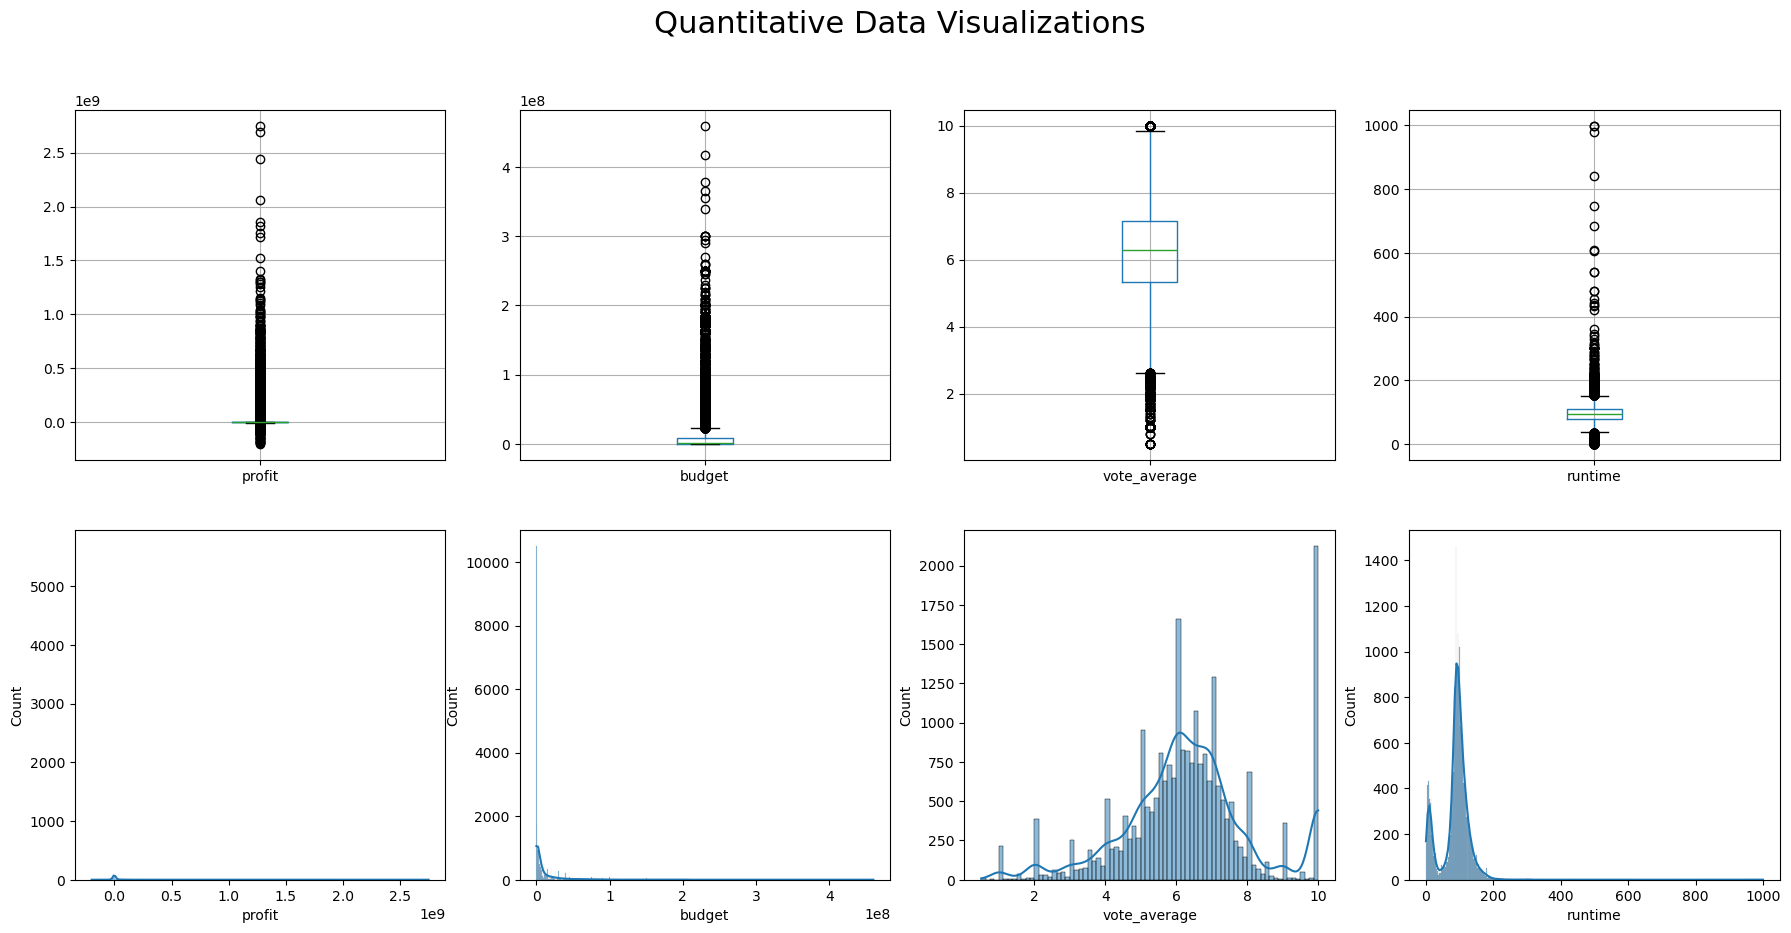

In [21]:
boxplotVisualize(df)

In [22]:
#Function to remove outliers based on IQR
def removeOutliersIQR(df, column):

    q1 = np.percentile(df[column], 25)
    q3 = np.percentile(df[column], 75)
    
    iqr = q3 - q1
    upperThreshold = q3 + (1.5 * iqr)
    lowerThreshold = q1 - (1.5 * iqr)
    
    df = df[(df[column] <= upperThreshold) & (df[column] >= lowerThreshold)]    
    
    return df

In [23]:
# remove outliers and display descriptive statistics
while True:
    shape = df.shape
    df = removeOutliersIQR(df, 'runtime')
    df = removeOutliersIQR(df, 'vote_average')
    df = removeOutliersIQR(df, 'budget')
    df = removeOutliersIQR(df, 'profit')
    if (df.shape == shape): break
df.describe()

,profit,budget,vote_average,runtime
count,7.141000e+03,7.141000e+03,7141.000000,7141.000000
mean,-4.729537e+05,5.786278e+05,5.705284,90.831956
std,6.822571e+05,6.522445e+05,1.376348,12.894554
min,-2.311727e+06,1.000000e+00,2.643000,60.000000
25%,-9.376180e+05,3.300000e+04,4.800000,83.000000
50%,-2.000000e+05,3.000000e+05,5.800000,90.000000
75%,-1.150000e+04,1.000000e+06,6.700000,99.000000
max,1.374000e+06,2.400005e+06,9.200000,123.000000


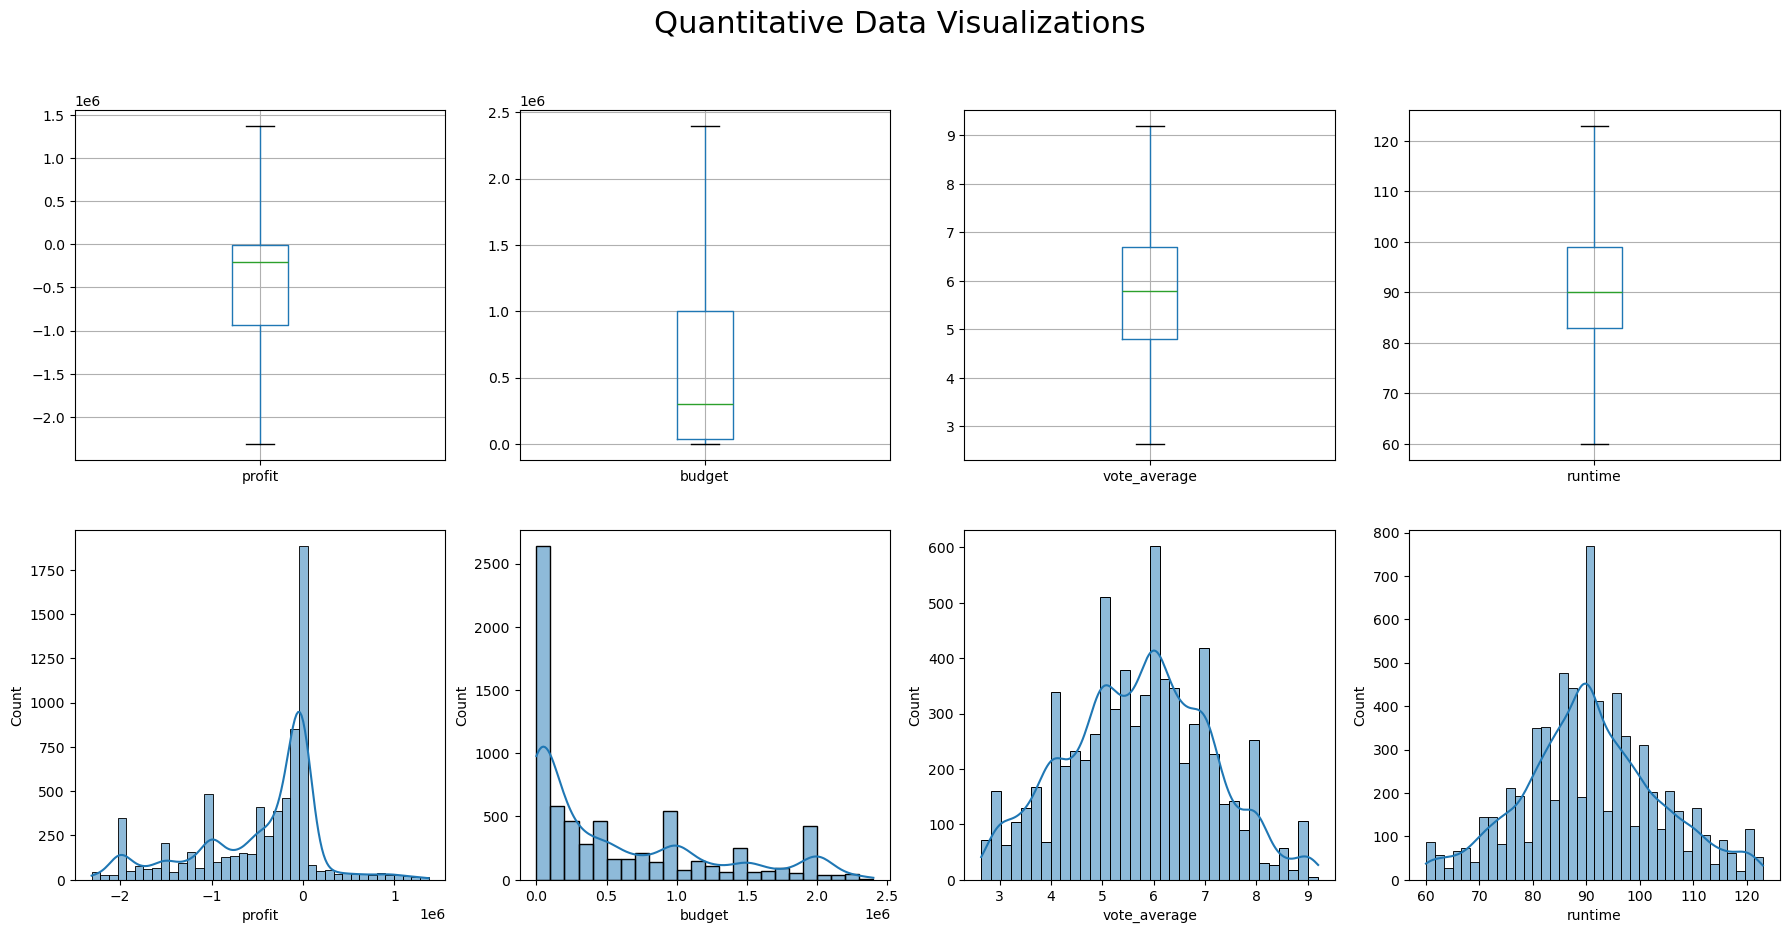

In [24]:
# visualize transformed quantitative variables
boxplotVisualize(df)

In [25]:
df.shape

(7141, 6)

# Categorical Variaables

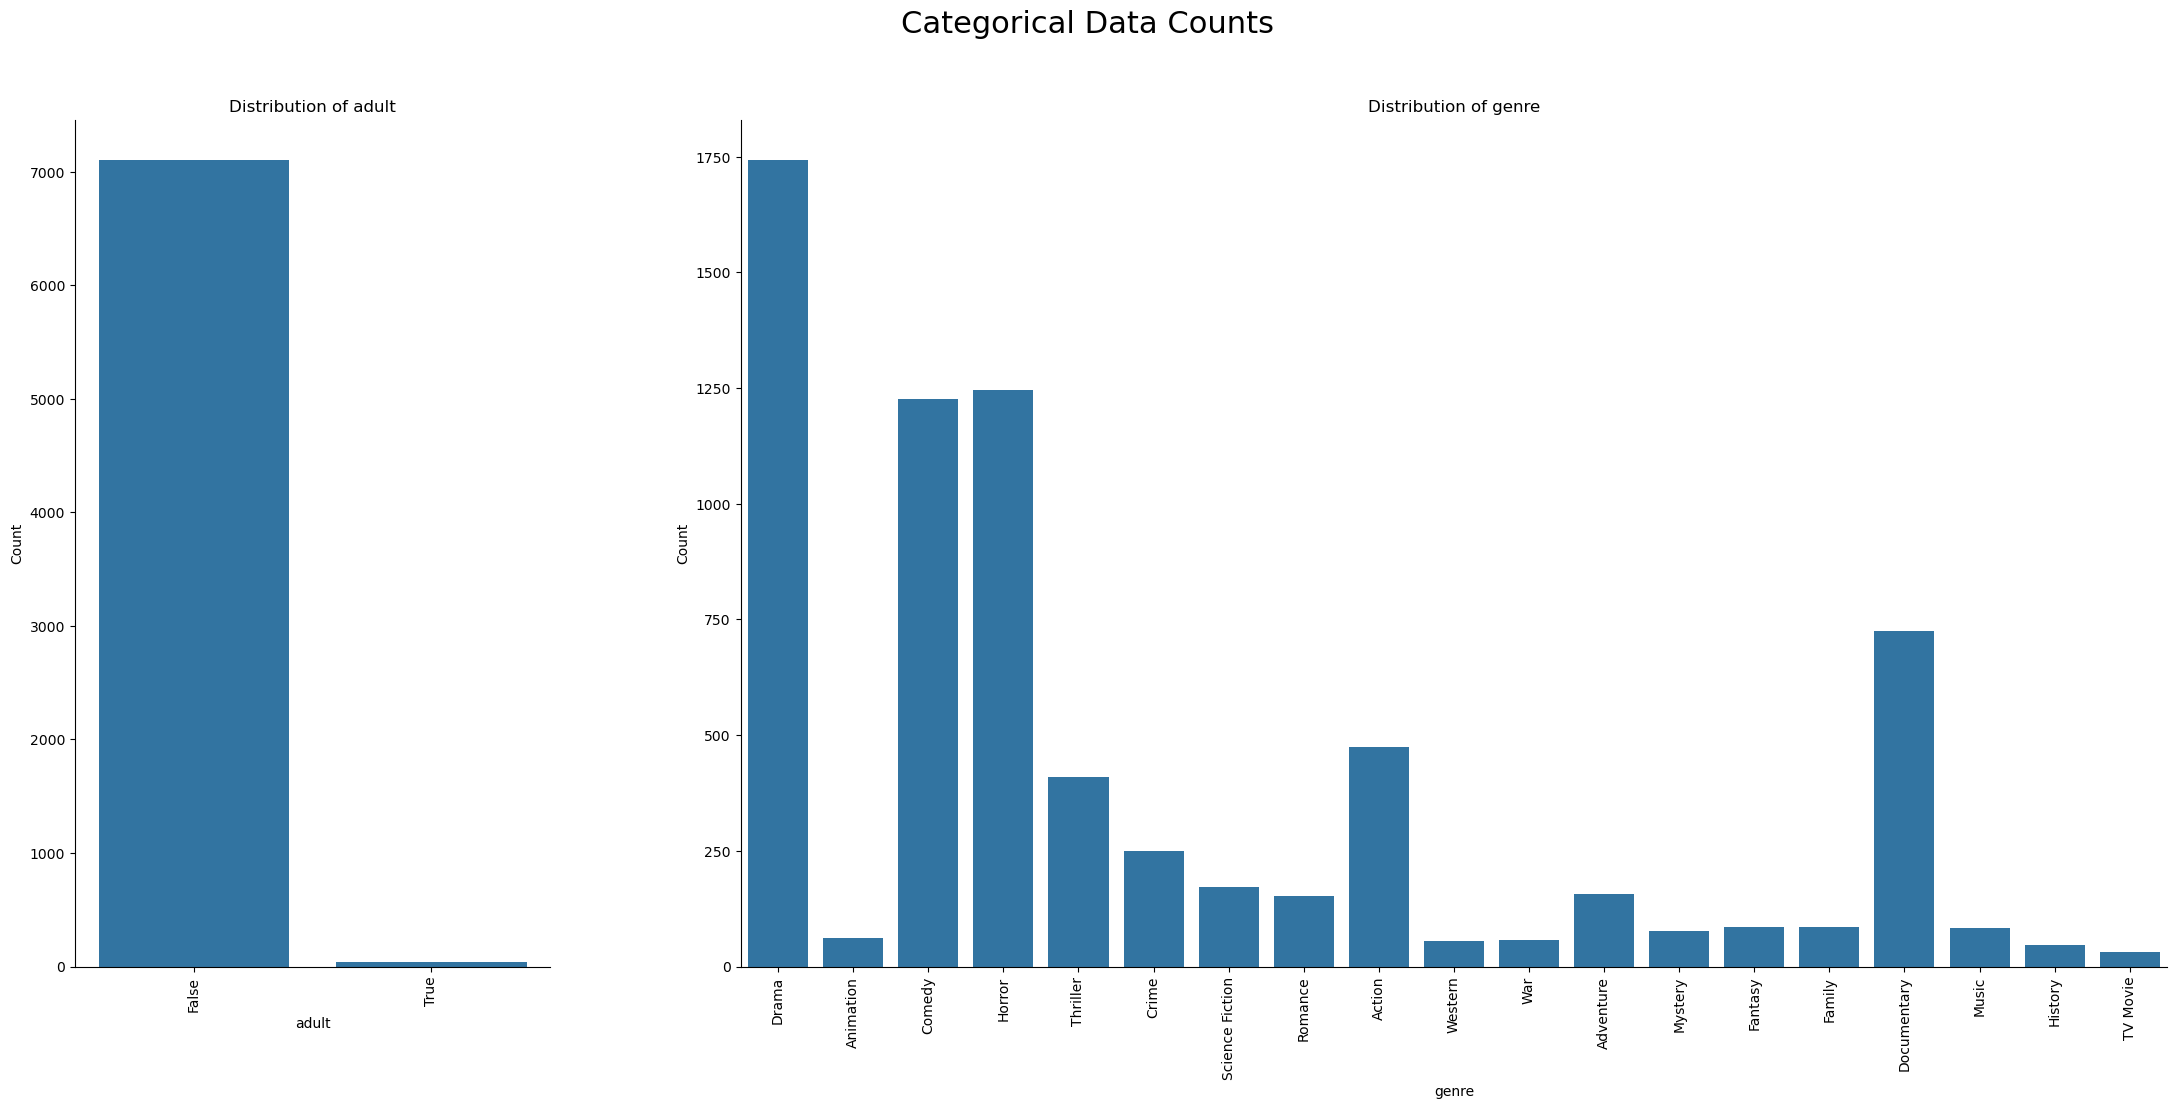

In [27]:
# Create catagorical visualizations
fig = plt.figure(figsize=(27, 11)) # set figsize
gs = GridSpec(1, 2, width_ratios=[1, 3]) # set number and resize subplots
ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]  # fits GridSpec to subplots
fig.suptitle('Categorical Data Counts', fontsize=22) # add title
# Variables to be visualized
columns = ['adult', 'genre']
# create and format countplots
for i in range(2):
    sns.countplot(x=columns[i], data=df, ax=ax[i]); ax[i].set_title('Distribution of ' + columns[i])
    ax[i].set_ylabel('Count'); ax[i].set_xlabel(columns[i])
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)
plt.subplots_adjust(hspace=.8)
plt.show()

In [28]:
# display adult count
df['adult'].sum()

38

In [29]:
# display genre counts
df['genre'].value_counts()

genre
Drama              1743
Horror             1246
Comedy             1227
Documentary         726
Action              474
Thriller            410
Crime               250
Science Fiction     173
Adventure           157
Romance             152
Fantasy              86
Family               85
Music                83
Mystery              76
Animation            62
War                  58
Western              56
History              46
TV Movie             31
Name: count, dtype: int64

In [30]:
# Drop genre with little representation
df = df[df['genre'] != 'TV Movie']

In [51]:
# sample each genre to consist of 31 entries
sampled_df = df.groupby('genre').apply(lambda x: x.sample(n=31, random_state=42), include_groups=True)

C:\Users\mattb\AppData\Local\Temp\ipykernel_14924\3043043601.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('genre').apply(lambda x: x.sample(n=31, random_state=42), include_groups=True)


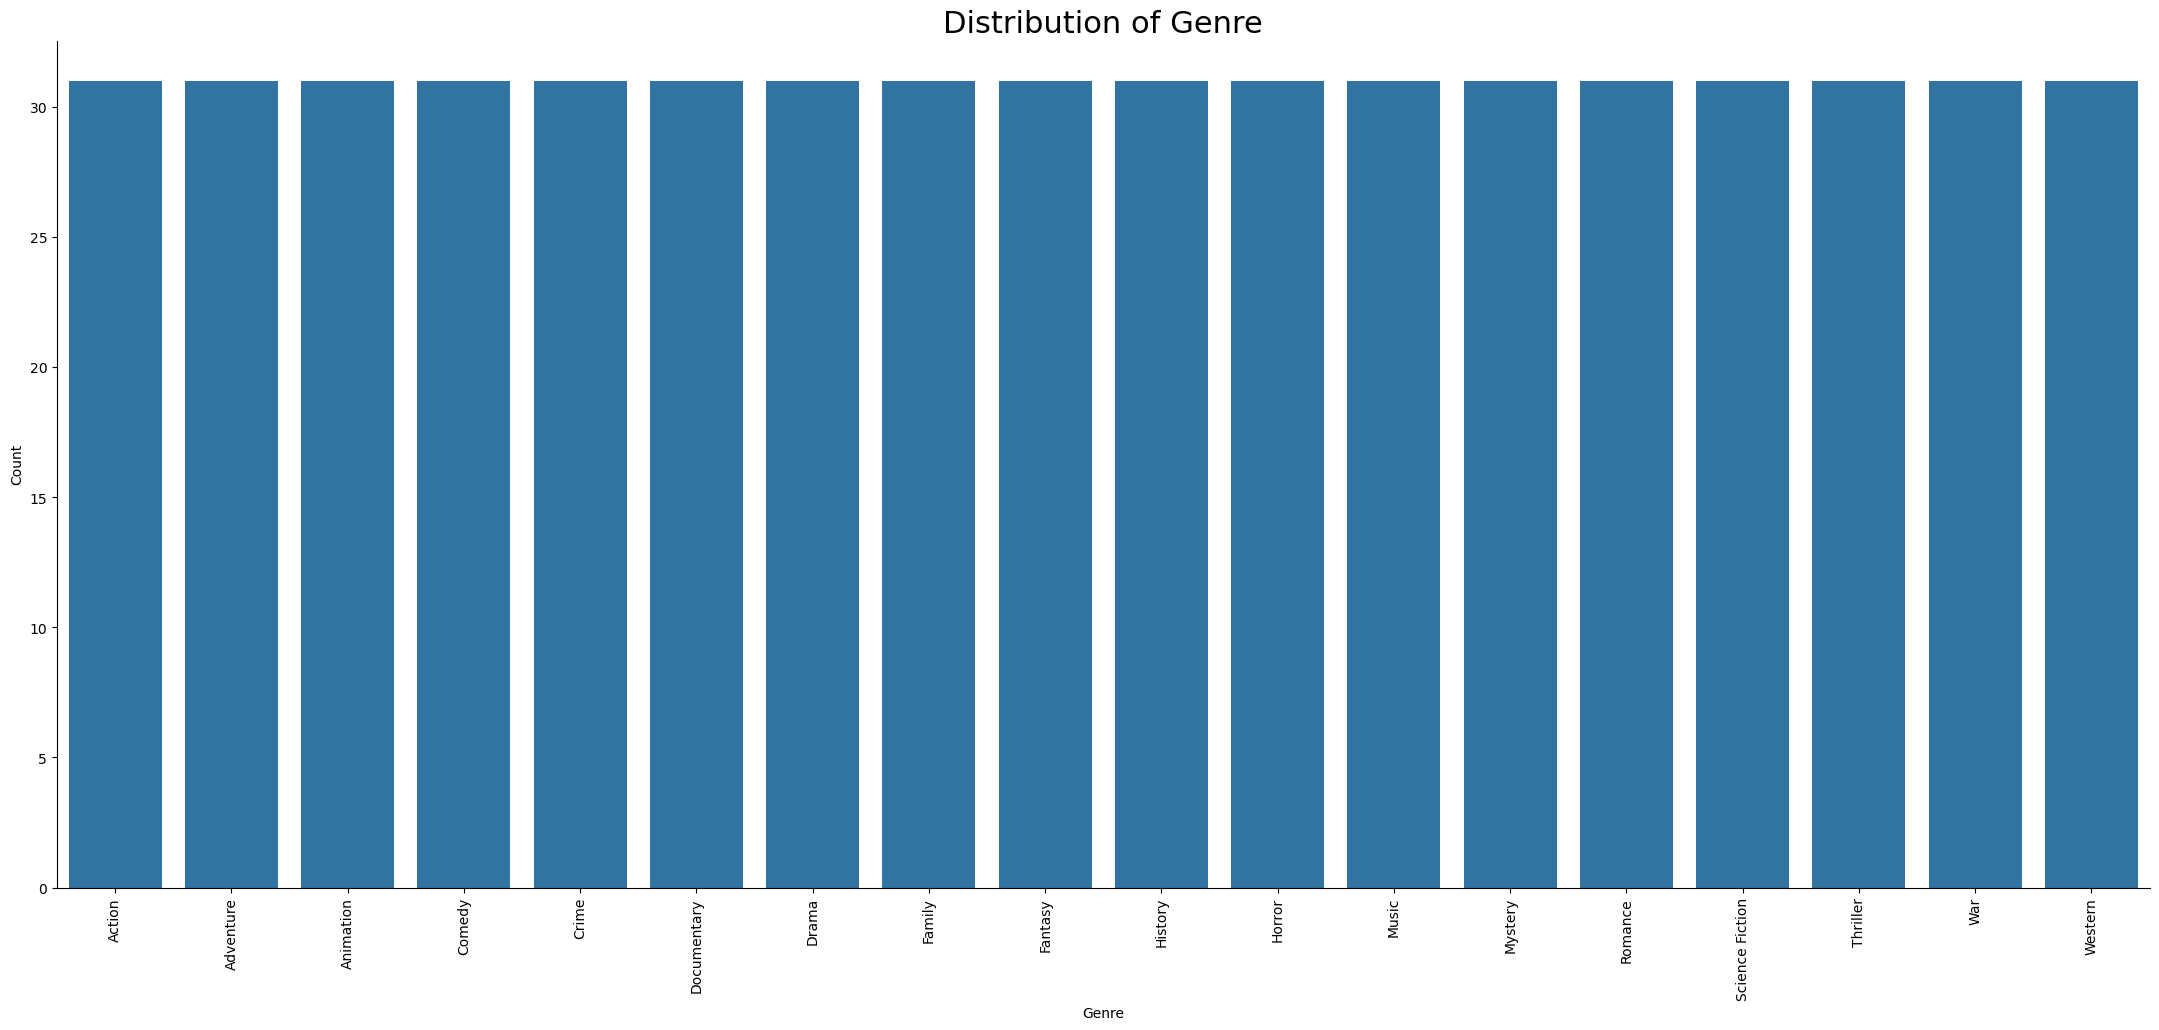

In [32]:
# Create a countplot for transformed genre
fig, ax = plt.subplots(figsize=(27, 11))
sns.countplot(x='genre', data=sampled_df, ax=ax)

ax.set_title('Distribution of Genre', fontsize='22'); ax.set_ylabel('Count'); ax.set_xlabel('Genre')
ax.tick_params(axis='x', rotation=90)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

plt.show()

In [53]:
# get dummy representation for genres 
sampled_df = pd.get_dummies(sampled_df, columns=['genre'], dtype='int', prefix='genre')
sampled_df.columns

Index(['profit', 'budget', 'vote_average', 'runtime', 'adult', 'genre__Action',
       'genre__Adventure', 'genre__Animation', 'genre__Comedy', 'genre__Crime',
       'genre__Documentary', 'genre__Drama', 'genre__Family', 'genre__Fantasy',
       'genre__History', 'genre__Horror', 'genre__Music', 'genre__Mystery',
       'genre__Romance', 'genre__Science Fiction', 'genre__Thriller',
       'genre__War', 'genre__Western'],
      dtype='object')

In [55]:
sampled_df.head()

profit   budget  vote_average  runtime  adult  genre__Action  \
genre                                                                          
Action 266408   -35000    35000         7.000       87  False              1   
       269432     7678     6654         8.000       81  False              1   
       8549   -1500000  1500000         7.000      113  False              1   
       326816 -1146442  1183424         8.000       98  False              1   
       14348  -1500000  1500000         4.414       90  False              1   

               genre__Adventure  genre__Animation  genre__Comedy  \
genre                                                              
Action 266408                 0                 0              0   
       269432                 0                 0              0   
       8549                   0                 0              0   
       326816                 0                 0              0   
       14348                  0                 0              0   

               genre__Crime  ...  genre__Fantasy  genre__History  \
genre                        ...                                   
Action 266408             0  ...               0               0   
       269432             0  ...               0               0   
       8549               0  ...               0               0   
       326816             0  ...               0               0   
       14348              0  ...               0               0   

               genre__Horror  genre__Music  genre__Mystery  genre__Romance  \
genre                                                                        
Action 266408              0             0               0               0   
       269432              0             0               0               0   
       8549                0             0               0               0   
       326816              0             0               0               0   
       14348               0             0               0               0   

               genre__Science Fiction  genre__Thriller  genre__War  \
genre                                                                
Action 266408                       0                0           0   
       269432                       0                0           0   
       8549                         0                0           0   
       326816                       0                0           0   
       14348                        0                0           0   

               genre__Western  
genre                          
Action 266408               0  
       269432               0  
       8549                 0  
       326816               0  
       14348                0  

[5 rows x 23 columns]

# Data Understanding/Visualization
## Scatterplots with Regression Line
To understand the relationship between the profit generated and the quantitative variables, the scatter plots below were created with the independent variables on the x-axis and profit, the dependent variable, on the y-axis.  A regression line was plotted on the same grid to illustrate the relationship.  The only category illustrating a clear linear relationship with profit was budget.  

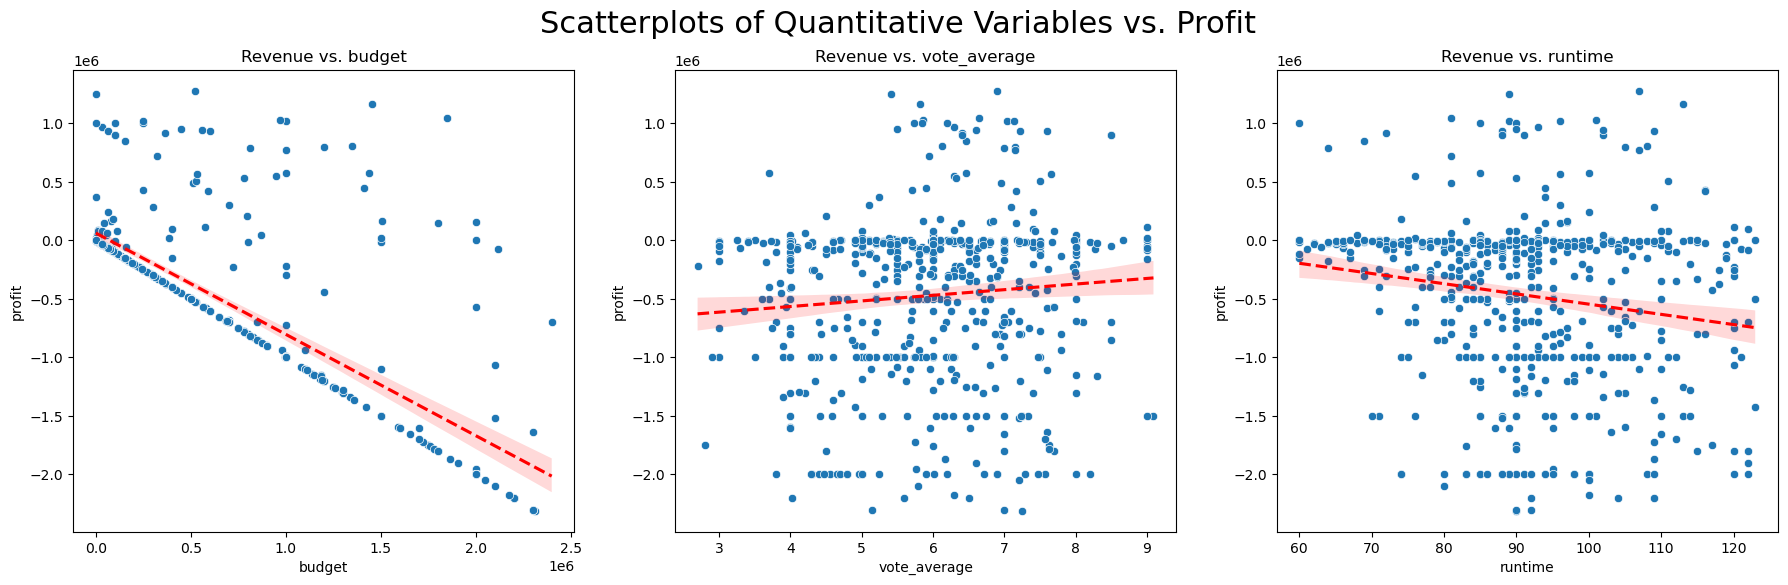

In [35]:
# columns to be visualized
columns = ['budget', 'vote_average', 'runtime']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6)) #set number of plots and figsize
fig.suptitle('Scatterplots of Quantitative Variables vs. Profit', fontsize=22) # set super title

# Create and format scatterplots with line of best fit
for i in range(3):
    sns.scatterplot(x=columns[i], y='profit', data=sampled_df, ax=axes[i])
    sns.regplot(x=columns[i], y='profit', data=sampled_df, ax=axes[i], scatter=False, color='red', line_kws={'linestyle':'--'})
    axes[i].set_title(f'Revenue vs. {columns[i]}')
    axes[i].set_xlabel(columns[i]); axes[i].set_ylabel('profit')
plt.show()

## Correlation Matrix

The correlation matrix below was created to verify the relationships between quantitaive variables.  Budget and profit had a (-.81) correlation coefficient, which indicates a strong positive linear relationship.  The variable vote_average scored lowest (.073), illustrating an extremely weak positive linear relationship.  Runtime illustrated a weak linear relationship with a value of (.16).

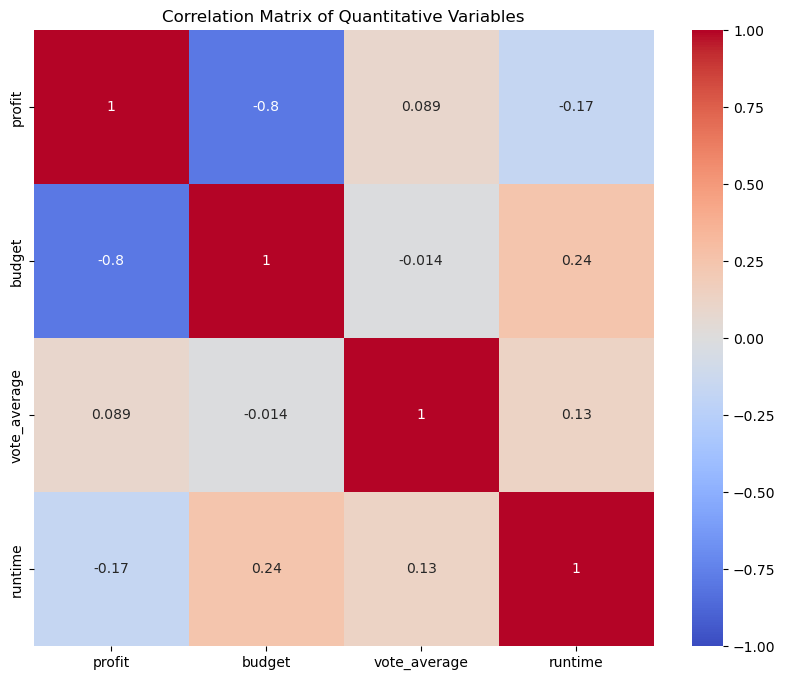

In [37]:
# variables to be included in correlation matrix
quantitative_df  = sampled_df[['profit', 'budget', 'vote_average', 'runtime']]

corr_matrix = quantitative_df.corr() # create correlation matrix
plt.figure(figsize=(10,8))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1) # create and format heatmap

plt.title('Correlation Matrix of Quantitative Variables') # set title
plt.show()

# Boxplots of Profit Distribution by Genre

In the code below, the dataset was transformed to understand the relationship between genres and profit, and a visualization consisting of boxplots for each genre was created.  The median profit value was calculated for each genre, and genres were plotted in ascending order by this metric.  This showed a positive relationship between profit genre when ordered by median.  The top 3 profit-producing genres starting with the most are crime, music, and adventure when assessed by median.  The bottom three, beginning with the least, are TV movie, thriller, then history.

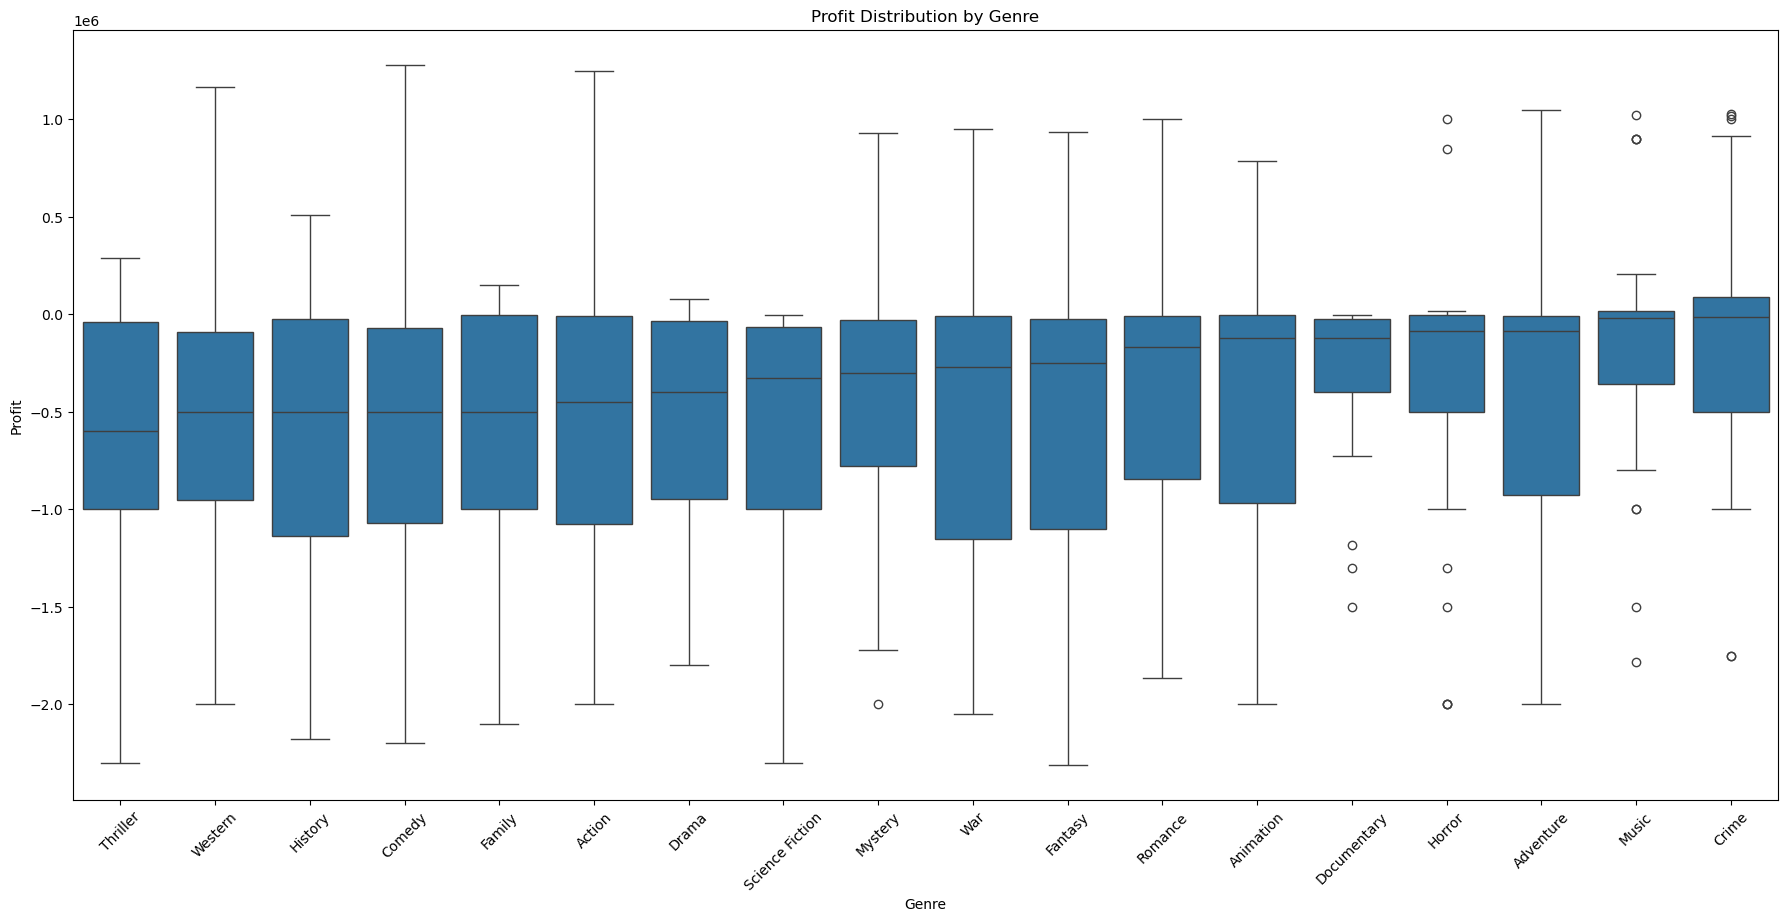

In [39]:
# convert df to long format in order to map genres individually
df_long = pd.melt(sampled_df, var_name='genre', value_name='has_genre', 
                  value_vars=[col for col in sampled_df.columns if col.startswith('genre_')])

# subset for rows where the genre is present
df_long = df_long[df_long['has_genre'] == 1]
# add revenue to df_long
df_long['profit'] = sampled_df['profit'].values
# remove genre_ prefix
df_long['genre'] = df_long['genre'].str.replace('genre_', '')
# Order genres by median revenue
median_revenue = df_long.groupby('genre')['profit'].median().sort_values()

# Create and format boxplots of genres ordered by median revenue
plt.figure(figsize=(22, 10))
sns.boxplot(x='genre', y='profit', data=df_long, order=median_revenue.index)

plt.title('Profit Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.show()


# Experiment 1: Multivariate Linear Regression

The first model is created using ordinary least squares regression.  This process fits a linear equation to the training dataset that minimizes the squared residuals, or the difference between the predicted values and actual values.  In this application, a constant is required to be included in the equation.  This iteration will include all the variables of interest.

Firstly, the dataset is split in x and y with x containing the predictor variables and y being the target variable 'profit'.  These are further split into testing and training sets to train and evaluate the model using unseen data.  The constant was initialized for both predictor subsets.  The training data was passed to statsmodels OLS function to calculate and return the multivariate linear regression model.

In [75]:
X = sampled_df.drop(columns=['profit', 'adult'], axis=1)
y = sampled_df['profit']

In [77]:
# split datasets into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
# Add constant
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [80]:
lm1 = sm.OLS(y_train, X_train).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     39.59
Date:                Mon, 28 Oct 2024   Prob (F-statistic):           4.22e-79
Time:                        21:16:19   Log-Likelihood:                -5574.6
No. Observations:                 390   AIC:                         1.119e+04
Df Residuals:                     369   BIC:                         1.127e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1.796e+05   1.62e+05     -1.110      0.268   -4.98e+05    1.39e+05
budget                    -0.8781      0.034    -25.995      0.000      -0.945      -0.812
vote_average            3.508e+04   1.74e+04      2.017      0.044     873.177    6.93e+04
runtime                  492.1033   1587.744      0.310      0.757   -2630.058    3614.264
genre__Action          -7.865e+04   8.79e+04     -0.895      0.372   -2.52e+05    9.42e+04
genre__Adventure        2.329e+05   7.72e+04      3.016      0.003     8.1e+04    3.85e+05
genre__Animation        7.803e+04   1.13e+05      0.692      0.489   -1.44e+05       3e+05
genre__Comedy          -2.365e+04   7.74e+04     -0.305      0.760   -1.76e+05    1.29e+05
genre__Crime             2.87e+05   8.84e+04      3.248      0.001    1.13e+05    4.61e+05
genre__Documentary     -1.215e+05   8.85e+04     -1.373      0.171   -2.96e+05    5.26e+04
genre__Drama           -1.391e+05   8.09e+04     -1.720      0.086   -2.98e+05    1.99e+04
genre__Family          -1.293e+05   8.97e+04     -1.441      0.150   -3.06e+05    4.71e+04
genre__Fantasy           -6.5e+04   8.43e+04     -0.771      0.441   -2.31e+05    1.01e+05
genre__History         -1.214e+05   8.21e+04     -1.479      0.140   -2.83e+05       4e+04
genre__Horror           5.981e+04   8.33e+04      0.718      0.473   -1.04e+05    2.24e+05
genre__Music            8.502e+04   8.34e+04      1.020      0.308   -7.89e+04    2.49e+05
genre__Mystery         -1.035e+05   9.73e+04     -1.064      0.288   -2.95e+05    8.78e+04
genre__Romance          8.936e+04   8.19e+04      1.091      0.276   -7.16e+04     2.5e+05
genre__Science Fiction -1.029e+05   8.08e+04     -1.274      0.203   -2.62e+05    5.59e+04
genre__Thriller        -1.175e+05   8.81e+04     -1.334      0.183   -2.91e+05    5.57e+04
genre__War             -7.806e+04   8.88e+04     -0.879      0.380   -2.53e+05    9.67e+04
genre__Western          6.886e+04   8.36e+04      0.824      0.411   -9.55e+04    2.33e+05
==============================================================================
Omnibus:                      245.198   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1736.179
Skew:                           2.729   Prob(JB):                         0.00
Kurtosis:                      11.778   Cond. No.                     1.64e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.03e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## P-Value Elimination
The following function eliminates the variable with the highest p-value above (.05) until all variables have a p-value below (.05).  This is a commonly used threshold to evaluate the significance of variables meaning variables with a p-value above the threshold are insignificant and do not effectively capture a relationship with the target variable.

The final model includes 6 significant predictor variables:
- budget
- genre_Adventure
- genre_Crime
- genre_Music
- genre_Romance

In [107]:
def pValueElimination(X_train, y_train):
    while True:
        lm = sm.OLS(y_train, X_train).fit()
        p_vals = lm.pvalues

        max_val = p_vals.max()
        var_name = p_vals.idxmax()
        
        if max_val > .05: X_train = X_train.drop(columns=[var_name])
        else: break
    return lm

lm1 = pValueElimination(X_train, y_train)

In [109]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 profit   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.758
Method:                 Least Squares   F-statistic:                              244.9
Date:                Mon, 28 Oct 2024   Prob (F-statistic):                   3.56e-117
Time:                        21:34:49   Log-Likelihood:                         -5581.1
No. Observations:                 390   AIC:                                  1.117e+04
Df Residuals:                     385   BIC:                                  1.119e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
budget              -0.8699      0.025    -34.608      0.000      -0.919      -0.821
genre__Adventure  2.958e+05   7.94e+04      3.725      0.000     1.4e+05    4.52e+05
genre__Crime      3.568e+05   9.04e+04      3.947      0.000    1.79e+05    5.35e+05
genre__Music      2.021e+05   8.03e+04      2.516      0.012    4.42e+04     3.6e+05
genre__Romance    1.667e+05    8.3e+04      2.009      0.045    3559.543     3.3e+05
==============================================================================
Omnibus:                      254.916   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1895.297
Skew:                           2.853   Prob(JB):                         0.00
Kurtosis:                      12.169   Cond. No.                     3.78e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Evaluation

In [122]:
X_test = X_test[['budget', 'genre__Adventure', 'genre__Crime', 'genre__Music', 'genre__Romance']]
# predict test data
y_pred = lm1.predict(X_test)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.0f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.0f}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.0f}")

# R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2:.3f}")

Mean Squared Error (MSE): 218619022277
Root Mean Squared Error (RMSE): 467567
Mean Absolute Error (MAE): 250867
R-squared (R²): 0.606


The R^2 value of the final multivariate linear regression model is (.606) meaning that the model effectively explains 60.6% of the variance in the data relative to profit generated.  The mean squared error, or the squared average of the residuals, was 218,619,022,277.  The RMSE was roughly 468k.  The MAE was roughly 25k illustrating the average residual.